# Importing files doesn't work as easily.
Idea: Add the vector_CD package to the python path.

Then try Executing this notebook (not necessarily within the vector_CD package).

In [2]:
import numpy as np
import math
import os, time, sys
from matplotlib import pyplot as plt

#### Local Files
# from vector_CD.data_generation import *
# import gen_data_vecCI_ext as mod1
import data_generation.mult_data_gen_methods as mech
import CD_methods.vec_CD_methods as cd
import metrics_vec_CD as met
######

import tigramite
import tigramite.data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

def lin_f(x): return x

ModuleNotFoundError: No module named 'gen_data_vecCI_ext'

In [6]:
def calculate(para_setup):
    
    para_setup_string, sam = para_setup
    paras = para_setup_string.split('-')
    paras = [w.replace("'","") for w in paras]
    
    data_gen = str(paras[0])
    d_macro = int(paras[1])
    d_micro = int(paras[2])
    T = int(paras[3])
    coeff = float(paras[4])
    auto = float(paras[5])
    contemp_frac = float(paras[6])
    pc_alpha = float(paras[7])
    tau_max = int(paras[8])
    method = str(paras[9])
    corr_type = str(paras[10])
    reg_type = str(paras[11])
    
    if len(paras)>12:
        internal_ER = float(paras[12]) #ER: erdos-renyi probability
        external_ER = float(paras[13])
    else:
        internal_ER = None
        external_ER = None
    
    # print(data_gen, d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, method, corr_type, reg_type)
    # print("METHOD", method)
    
    #############################################
    ##  Data Generation 
    #############################################    
    
    if 'coarse_dag' in data_gen:
        data, true_graph = mech.data_coarse_dag(data_gen,sam,d_macro,d_micro,coeff,auto,tau_max,contemp_frac,T,
                                          internal_ER = internal_ER,
                                          external_ER = external_ER)
    elif 'cbm' in data_gen:
        data, true_graph = mech.data_mrf(d_macro,d_micro, sam, T)  
        
    elif 'mrf_ts' in data_gen:
        data, true_graph = mech.data_mrf_ts(data_gen,sam,d_macro,d_micro,coeff,auto,tau_max,contemp_frac,T,
                                          internal_er = internal_ER,
                                          external_er = external_ER)    
    elif 'savar' in data_gen:
        data, true_graph = mech.data_savar(d_macro,d_micro, sam, T, coeff, auto, contemp_frac, tau_max)
        
    #############################################
    ##  Cond ind test
    #############################################
    if 'vec' in method:
        print("vector PCMCI running......")
        cond_ind_test = cd.get_cmi(reg_type, corr_type)
        
    elif 'avg' in method or 'vanilla' in method:
        print("avg or vanilla PCMCI running......")
        cond_ind_test = ParCorr(
        significance='analytic', 
        recycle_residuals=True)
        
    elif 'pca_pcmci' in method:
        print("Principal component PCMCI running......")
        if method == 'pca_pcmci':
            p_comps = 1
            cond_ind_test = ParCorr(
            significance='analytic', 
            recycle_residuals=True)
        else:
            p_comps  = int(method.replace('pca_pcmci_',''))
            if p_comps==1:
                cond_ind_test = ParCorr(
                significance='analytic', 
                recycle_residuals=True)
            elif p_comps > d_micro:
                raise ValueError("principal components can't be larger than d_micro")
            else:
                cond_ind_test = cd.get_cmi(reg_type, corr_type)
    
    #############################################
    ##  Vec-CD Methods
    #############################################
    computation_time_start = time.time()

    if 'vec_pcmci' in method:
        graph = cd.vec_pcmci(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha)
    elif 'avg_pcmci' in method:
        graph = cd.avg_pcmci(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha)
    elif 'pca_pcmci' in method:
        graph = cd.pca_pcmci(data, d_macro, d_micro, p_comps, cond_ind_test, tau_max, pc_alpha)
    elif 'vanilla_pcmci' in method:
        graph = cd.vanilla_pcmci(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha)
        
    computation_time_end = time.time()
    computation_time = computation_time_end - computation_time_start
        
    tp.plot_graph(
    graph=true_graph,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()
    
    # print('Graph',graph)
    tp.plot_graph(
    graph=graph,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()
        
    return {
            'true_graph':true_graph,
            'graph':graph,
            'computation_time': computation_time,
            }  

In [7]:
def compute_reps(config_list, samples):
    all_configs = dict([(conf, {
        'results':{}, 
        "graphs":{}, 
        "true_graph":{}, 
        "computation_time":{},} ) for conf in config_list])
    job_list = [(conf, i) for i in range(samples) for conf in config_list]
    config_chunks = [job_list]

    def process_chunks(job_id, chunk):
        results = {}
        num_here = len(chunk)
        time_start_process = time.time()
        for isam, config_sam in enumerate(chunk):
            print(config_sam,'\n------------\n')
            results[config_sam] = calculate(config_sam)
        return results

    for job_id, chunk in enumerate(config_chunks):
        tmp = process_chunks(job_id, chunk)
        for conf_sam in list(tmp.keys()):
            config = conf_sam[0]
            sample = conf_sam[1]
            all_configs[config]['results'][sample] = tmp[conf_sam]
        
    return all_configs

In [8]:
ER = True # ER indicates that the internal and extetnal densities are given in terms of ER probabilities
if ER: 
    anyconfigurations = [] 
    for data_gen in ['mrf_ts']:#, 'coarse_dag','mrf_ts','mrf','savar']:    
        for d_macro in [3]:
            for d_micro in [5]:   
                for coeff in [0.5]:
                    for auto in [0.3]:
                        for contemp_frac in [1.]:
                            for T in [200]:
                                method_list = ['pca_pcmci_2']
                                #['vec_pcmci','avg_pcmci','pca-pcmci','vanilla_pcmci']
                                for method in method_list: 
                                    for corr_type in ['gcm_gmb']:# ['maxcorr, gcm, linear_hsic']:
                                        for reg_type in ['ols']: #['ridge','pls']:
                                            for pc_alpha in [0.01]:
                                                for tau_max in [0]:
                                                    for internal_ER in [0.3]:
                                                        for external_ER in [0.5]:
                                                            para_setup = (data_gen, d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, method, corr_type, reg_type, internal_ER, external_ER)
                                                            name = '%s-'*len(para_setup) % para_setup
                                                            name = name[:-1]
                                                            anyconfigurations += [name]

    config_list = anyconfigurations

In [9]:
config_list

['mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5']

('mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5', 0) 
------------

Principal component PCMCI running......


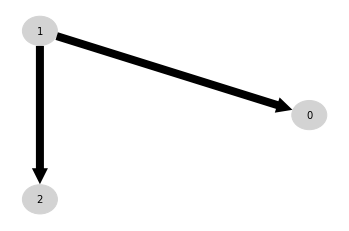

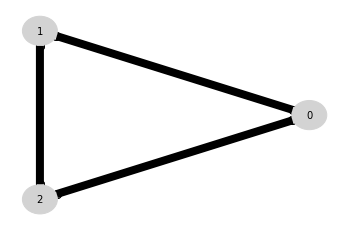

('mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5', 1) 
------------

Principal component PCMCI running......


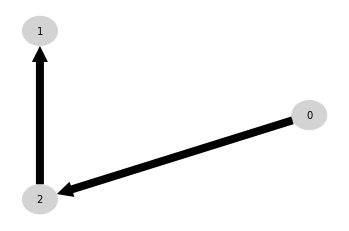

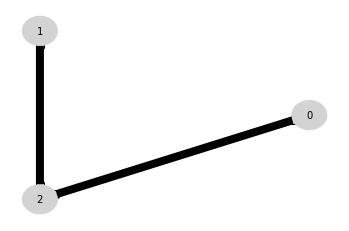

In [10]:
samples = 2 #not sample size, but number of repetitions
all_configs = compute_reps(config_list, samples)